In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import dill as pickle

# Data Preprocessing

In [2]:
# fetch the data
nio = yf.Ticker("NIO")
nio

yfinance.Ticker object <NIO>

In [3]:
#Get historical data
nio_data = nio.history(start ="2015-01-01", end=date.today(), interval="1d")

nio_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-10,42.669998,43.430000,42.160000,42.759998,34757300,0,0
2021-06-11,42.930000,46.259998,42.759998,45.680000,85407300,0,0
2021-06-14,45.950001,47.250000,45.580002,46.549999,65288400,0,0
2021-06-15,46.209999,46.380001,45.040001,45.150002,44755600,0,0
2021-06-16,44.230000,45.130001,43.770000,45.020000,47268900,0,0


### Data Visualization

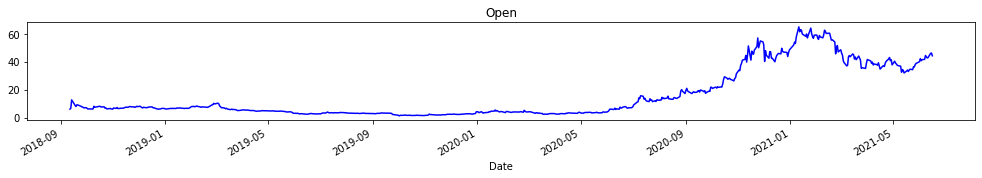

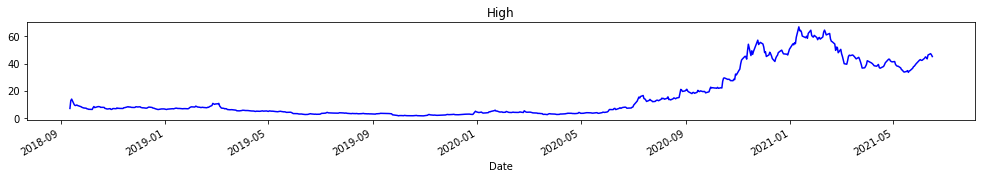

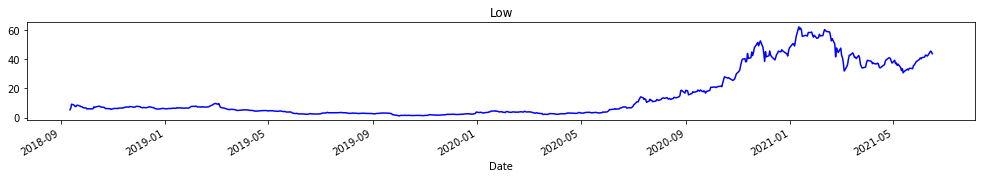

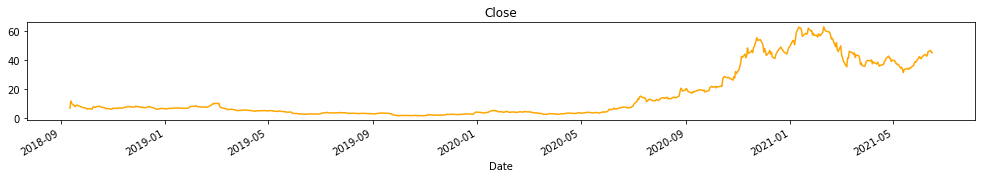

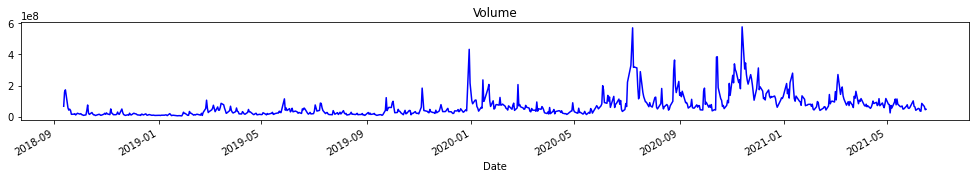

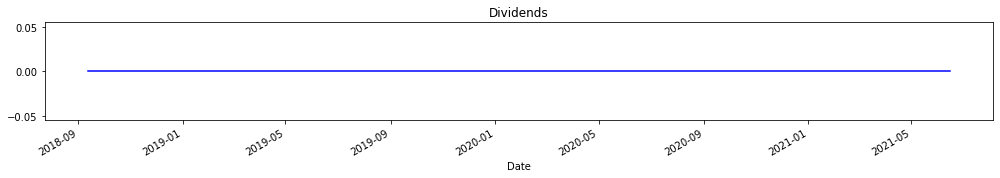

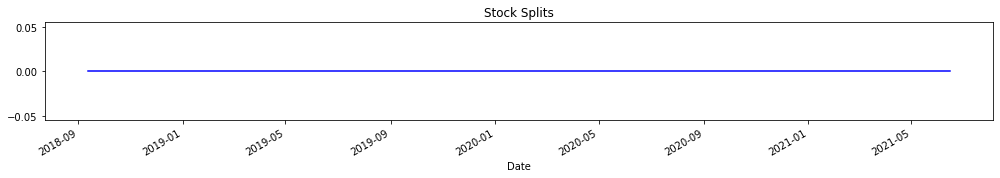

In [4]:
%matplotlib inline

for col in nio_data.columns:
    color="orange" if col == "Close" else "blue"
    nio_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
nio_data = nio_data.reset_index()
nio_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-09-12,6.00,6.93,5.35,6.60,66849000,0,0
1,2018-09-13,6.62,12.69,6.52,11.60,158346500,0,0
2,2018-09-14,12.66,13.80,9.22,9.90,172473600,0,0
3,2018-09-17,9.61,9.75,8.50,8.50,56323900,0,0
4,2018-09-18,8.73,9.10,7.67,7.68,41827600,0,0


In [6]:
#check if date is in datetime format
nio_data.Date.dtype

dtype('<M8[ns]')

In [7]:
#save the dataframe as csv
nio_data.to_csv("nio.csv")

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [8]:
#Extracting the date and close price columns
nio_df = nio_data[["Date", "Close"]]
nio_df.head()

,Date,Close
0,2018-09-12,6.60
1,2018-09-13,11.60
2,2018-09-14,9.90
3,2018-09-17,8.50
4,2018-09-18,7.68


In [9]:
#rename the columns
nio_df = nio_df.rename(columns={'Date': 'ds', 'Close': 'y'})
nio_df.head()

,ds,y
0,2018-09-12,6.60
1,2018-09-13,11.60
2,2018-09-14,9.90
3,2018-09-17,8.50
4,2018-09-18,7.68


### Splitting the Data

In [10]:
index = int(0.8 * nio_df.shape[0])
train_df = nio_df[:index]
test_df = nio_df[index:]

In [11]:
print(train_df.shape)
print(test_df.shape)

(556, 2)
(139, 2)


### Hyperparameter Tuning

In [12]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [13]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [14]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [15]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
587,2023-06-30,343.493207,-271.676308,976.304624
588,2023-07-31,347.408749,-300.499091,1014.192883
589,2023-08-31,352.369074,-316.608657,1049.508912
590,2023-09-30,352.404934,-345.865514,1080.185031
591,2023-10-31,368.667052,-361.835630,1129.058479


## Plotting the Forecast

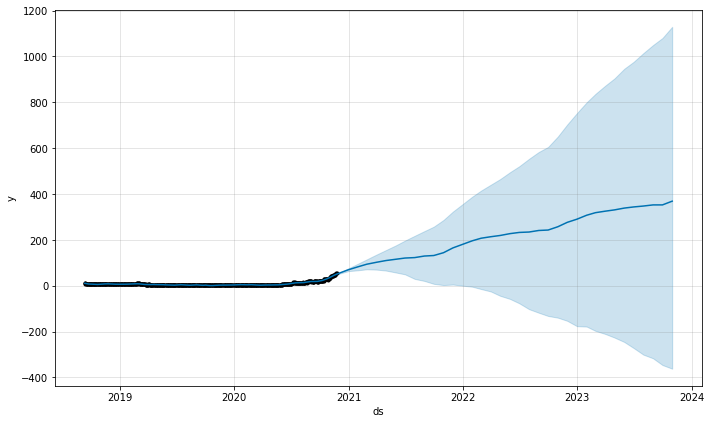

In [16]:
ax = model.plot(forecast);

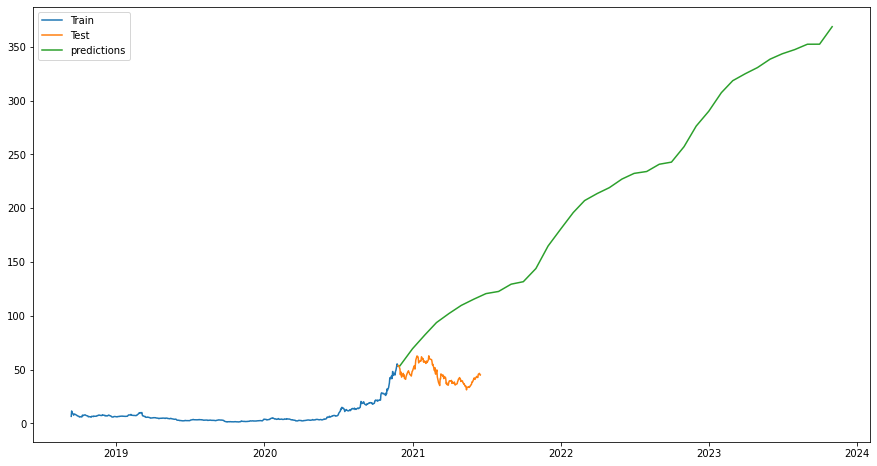

In [17]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

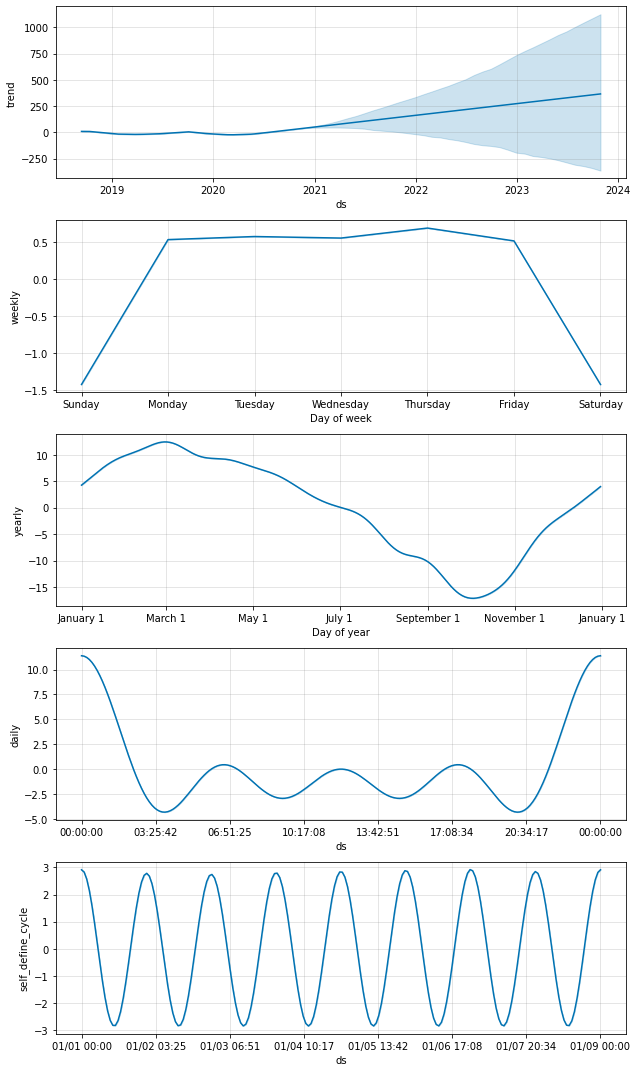

In [18]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [19]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365} days', horizon='100 days', period='180 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-18 00:00:00 and 2020-08-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
136,2020-11-18,21.444921,18.108064,24.769971,45.060001,2020-08-16
137,2020-11-19,21.541223,18.041885,24.859235,48.450001,2020-08-16
138,2020-11-20,21.542178,18.052742,24.787158,49.250000,2020-08-16
139,2020-11-23,22.143391,18.296977,25.729007,55.380001,2020-08-16
140,2020-11-24,22.146085,18.254493,25.618792,53.509998,2020-08-16


In [21]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,1.314477,1.146506,0.988210,0.172420,0.176290,0.428571
1,10 days,3.041426,1.743968,1.344391,0.195131,0.227873,0.357143
2,11 days,4.192287,2.047507,1.593947,0.201352,0.227873,0.321429
3,12 days,4.719718,2.172491,1.752792,0.203761,0.220149,0.285714
4,13 days,4.815630,2.194454,1.797251,0.218125,0.243235,0.250000


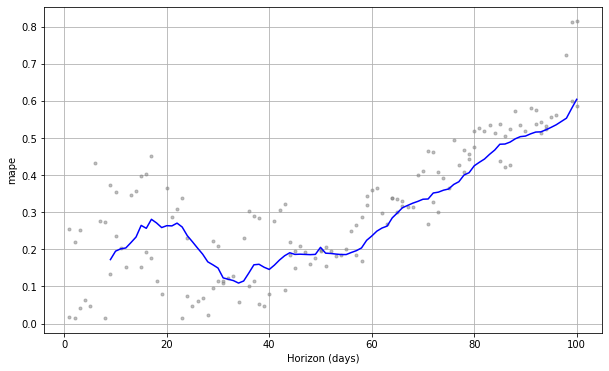

In [22]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [23]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [24]:
m.fit(train_df)

In [25]:
pickle.dump(m,open("nio.pkl","wb"))

In [26]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as nio:
    json.dump(model_to_json(m), nio)

In [27]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
587,2023-06-30,395.571404,-234.346005,971.621343
588,2023-07-31,402.092056,-267.261056,1018.906499
589,2023-08-31,404.936936,-300.342894,1052.473367
590,2023-09-30,404.670826,-332.702826,1084.639730
591,2023-10-31,418.577181,-356.927877,1128.406478


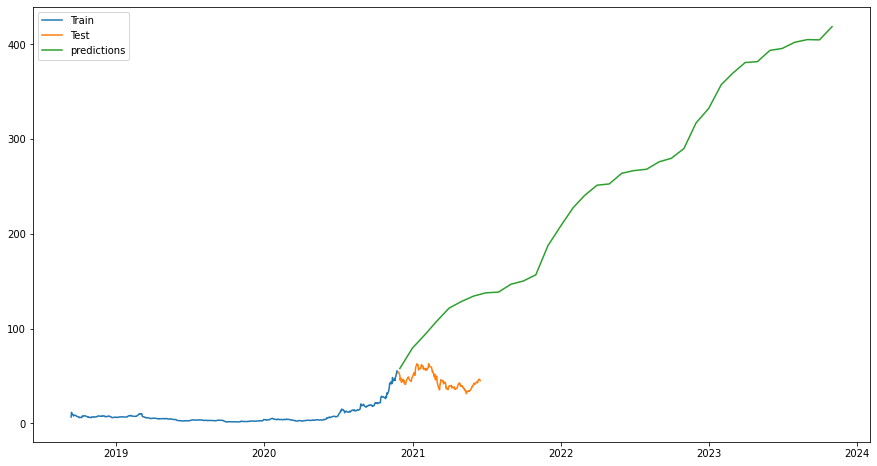

In [28]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [29]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365} days', horizon='100 days', period='180 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-18 00:00:00 and 2020-08-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,3.414071,1.847720,1.353226,0.227314,0.077446,0.357143
1,10 days,7.298012,2.701483,2.005550,0.302022,0.177045,0.285714
2,11 days,9.940206,3.152809,2.422869,0.321697,0.268124,0.214286
3,12 days,11.616556,3.408307,2.751892,0.338230,0.284222,0.142857
4,13 days,12.452452,3.528803,2.967393,0.392830,0.313540,0.107143


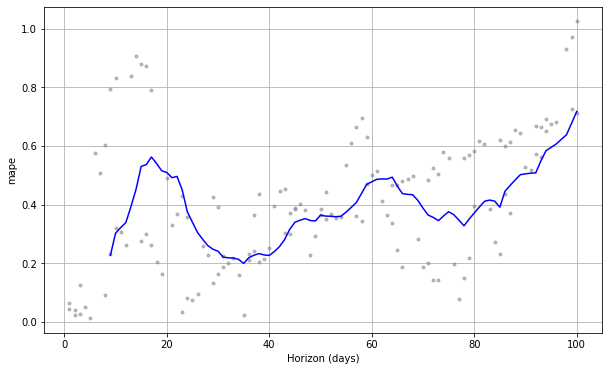

In [31]:
plot_cross_validation_metric(cv_results, metric='mape');